In [1]:
using Revise

In [2]:
using Distributed
procs_to_use = 20

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@everywhere @consts begin
    λ = 626e-9
    Γ = 2π* 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]


In [266]:
@everywhere sim_params = @params_mnt begin

#     # Resonant light to see if pushing happens
#     B_gradient = +75
#     B_offset = (0e-3, 0e-3, 0e-3)
#     B_ramp_time = 4e-3
    
#     s1 = 2.0/2
#     s2 = 4.0/2
#     s3 = 4.0/2
#     s4 = 0.0/2
#     Δ1 = +7.0
#     Δ2 = +7.0 - 0.50
#     Δ3 = +7.0 + 1.00
#     Δ4 = +7.0 + 2.50
#     pol1_x = [1,0,0]
#     pol2_x = [0,0,1]
#     pol3_x = [1,0,0]
#     pol4_x = [0,0,1]
    
#     s_ramp_time = 4e-3
#     s_ramp_to = 1.0
    
#     pol_imbalance = 0.03
#     s_imbalance = (0., 0., 0.)
#     retro_loss = 0.0
#     off_center = (2, 2, 2, 2, 2, 2) .* 1e-3
#     pointing_error = (0, 0, 0, 0, 0.1, 0)
    
#     # Resonant light to see if pushing happens
#     B_gradient = +75
#     B_offset = (0e-3, 0e-3, 0e-3)
#     B_ramp_time = 4e-3
    
#     s1 = 2.0/2
#     s2 = 4.0/2
#     s3 = 4.0/2
#     s4 = 0.0/2
#     Δ1 = +7.0
#     Δ2 = +7.0 - 0.50
#     Δ3 = +7.0 + 1.00
#     Δ4 = +7.0 - 1.00
#     pol1_x = [1,0,0]
#     pol2_x = [0,0,1]
#     pol3_x = [1,0,0]
#     pol4_x = [0,0,1]
    
#     s_ramp_time = 4e-3
#     s_ramp_to = 1.0
    
#     pol_imbalance = 0.03
#     s_imbalance = (0., 0., 0.)
#     retro_loss = 0.0
#     off_center = (2, 2, 2, 2, 2, 2) .* 1e-3
#     pointing_error = (0, 0, 0, 0, 0.1, 0)
    
    # Resonant light to see if pushing happens
    B_gradient = +30
    B_offset = (0e-3, 0e-3, 0e-3)
    B_ramp_time = 15e-3
    
    s1 = 2.0/2
    s2 = 4.0/2
    s3 = 0.0/2
    s4 = 0.0/2
    Δ1 = +7.0
    Δ2 = +7.0 - 0.50
    Δ3 = +7.0 + 1.00
    Δ4 = +7.0 - 1.00
    pol1_x = [1,0,0]
    pol2_x = [0,0,1]
    pol3_x = [1,0,0]
    pol4_x = [0,0,1]
    
    s_ramp_time = 4e-3
    s_ramp_to = 1.0
    
    pol_imbalance = 0.03
    s_imbalance = (0., 0., 0.)
    retro_loss = 0.0
    off_center = (2, 2, 2, 2, 2, 2) .* 1e-3
    pointing_error = (0, 0, 0, 0, 0.1, 0)
    
end
;

### Calculate transition dipole moments

In [267]:
@everywhere begin
    include("define_CaOH_states.jl")
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)
end
;

### Define lasers

In [268]:
@everywhere begin
    include("define_lasers.jl")
    # include("define_lasers_extra.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

In [269]:
# TODO:
# Try another frequency component that has two-photon detuning red of both J=3/2 hyperfine components
# Try moving the extra frequency components to the J=1/2 state
## (1/5/24) NOTE that the polarization of laser 4 was set to be the same as laser 3 no matter what when previously trying this 

# TODO experimentally:
# Increase overall intensity to get higher scattering rate, then reoptimize relative intensities
# Power scan (100) - and other repumpers???

### Define Zeeman Hamiltonian

In [270]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [271]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [272]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat
)
;

In [273]:
@everywhere begin
    t_start = 0.0
    t_end   = 20e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0.5e-3) ./ (1/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
end

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p)

cb = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=5e-4, callback=cb, saveat=1000, maxiters=80000000, progress=true, progress_steps=200000)
;

ODE   0%|█                                              |  ETA: N/A
ODE   7%|████                                           |  ETA: 0:00:33
ODE  15%|████████                                       |  ETA: 0:00:30
ODE  23%|███████████                                    |  ETA: 0:00:27
ODE  30%|███████████████                                |  ETA: 0:00:24
ODE  38%|██████████████████                             |  ETA: 0:00:22
ODE  45%|██████████████████████                         |  ETA: 0:00:19
ODE  53%|█████████████████████████                      |  ETA: 0:00:16
ODE  61%|█████████████████████████████                  |  ETA: 0:00:14
ODE  68%|████████████████████████████████               |  ETA: 0:00:11
ODE  76%|████████████████████████████████████           |  ETA: 0:00:09
ODE  83%|████████████████████████████████████████       |  ETA: 0:00:06
ODE  91%|███████████████████████████████████████████    |  ETA: 0:00:03
ODE  98%|███████████████████████████████████████████████|  ETA: 0:00

 38.404960 seconds (4.89 M allocations: 322.359 MiB, 0.28% gc time, 9.32% compilation time)


ODE 100%|███████████████████████████████████████████████| Time: 0:00:34


In [274]:
plot_us = sol.u
plot_ts = sol.t
x_trajectories = [real(u[n_states + n_excited + 1]) for u in plot_us]./k*1e3
y_trajectories = [real(u[n_states + n_excited + 2]) for u in plot_us]./k*1e3
z_trajectories = [real(u[n_states + n_excited + 3]) for u in plot_us]./k*1e3
;

In [275]:
plot(sol.t .* (1e3/Γ), z_trajectories, 
    legend=nothing,
    xlabel="Time (ms)",
    ylabel="z position (mm)"
)

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [276]:
prob.p.n_scatters / t_end

481450.0

### Run simulation for multiple particles in parallel

In [277]:
@everywhere function prob_func(prob, i, repeat)
    
     lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
    
    # Define initial conditions for the molecule
    cloud_size = @with_unit 0.5 "mm"
    particle = Particle()
    particle.r = (rand(Normal(0., cloud_size)), rand(Normal(0.1e-3, cloud_size)), rand(Normal(0.1e-3, cloud_size))) ./ (1/k)
    
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0
    
    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)
    
    callback = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
    
    prob = ODEProblem(ψ_stochastic_potential!, p.ψ, t_span, p, callback=callback, reltol=5e-4, saveat=4000, maxiters=80000000)
    
    return prob
end
;

In [278]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
;

In [279]:
n_molecules = 100
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
;

299.934024 seconds (3.59 M allocations: 189.796 MiB, 0.04% gc time, 1.72% compilation time)


In [280]:
x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([],n_molecules)) 
z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
photons_scattered = zeros(n_molecules)

times = Array{Vector{Float64}}(fill([],n_molecules))

for i ∈ 1:n_molecules
    sol_u = ensemble_sol[i].u
    sol_t = ensemble_sol[i].t
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]
    
    x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
    y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
    z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
    
    photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters
    
    times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i], y_trajectories[i], z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

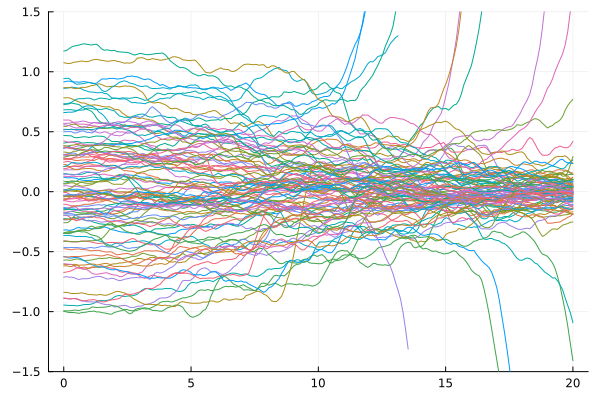

In [288]:
lim = 1.5
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, z_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()

In [289]:
function survived(i, t_end, times)
    return t_end ≈ times[i][end]
end

survived_molecules = [i for i ∈ 1:n_molecules if survived(i, t_end, times)]

survived_times = times[survived_molecules]

survived_x_trajectories = x_trajectories[survived_molecules]
survived_y_trajectories = y_trajectories[survived_molecules]
survived_z_trajectories = z_trajectories[survived_molecules]

survived_x_velocities = x_velocities[survived_molecules]
survived_y_velocities = y_velocities[survived_molecules]
survived_z_velocities = z_velocities[survived_molecules]
;

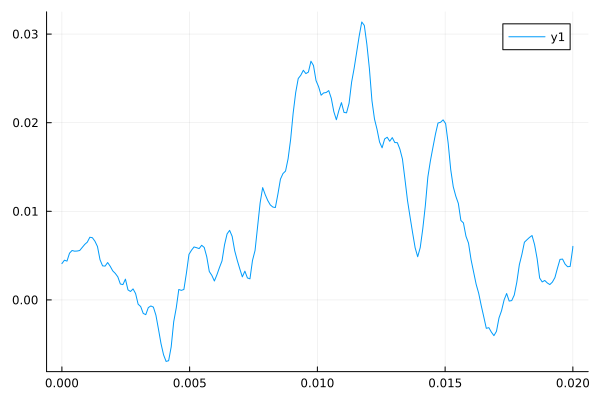

In [290]:
x_centers = mean(survived_z_trajectories)
plot(survived_times[1], x_centers)

In [291]:
y_centers = mean(survived_y_trajectories)
plot(survived_times[1], y_centers)

In [302]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.2:0.02:0.2)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
    σ, x0, A = v_fit.param
    
    # display(v_fit.param)
    # plot(v, Gaussian(v, v_fit.param))
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

In [303]:
xs = [x_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
ys = [y_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]
zs = [z_trajectories[i][end] for i ∈ (1:n_molecules)[survived_molecules]]

hist_data = fit(Histogram, ys, -0.3:0.02:0.3)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(ys, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)

3-element Vector{Float64}:
 0.14675576686627675
 0.018850794080001006
 2.8270551822779653

In [304]:
cloud_size_fitted(zs)

0.07863676446642649

In [305]:
plot_ts = 0:0.1e-3:19.9e-3
cloud_sizes = [cloud_size(t, 
        times[survived_molecules], 
        x_trajectories[survived_molecules], 
        y_trajectories[survived_molecules], 
        z_trajectories[survived_molecules]) 
    for t ∈ plot_ts]
;

In [306]:
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_x_trajectories]) for i ∈ eachindex(x_trajectories[survived_molecules][1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_y_trajectories]) for i ∈ eachindex(y_trajectories[survived_molecules][1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ survived_z_trajectories]) for i ∈ eachindex(z_trajectories[survived_molecules][1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

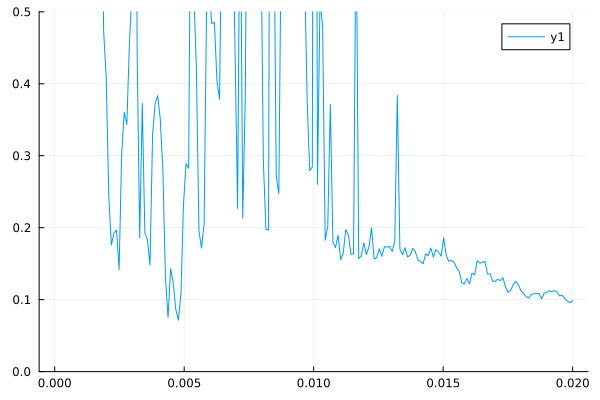

In [307]:
plot(survived_times[1], cloud_sizes_fitted, ylim=(0,0.5))

In [308]:
cloud_sizes_fitted

203-element Vector{Float64}:
 1.5849281440507292
 2.4799941891423534
 1.9120165313498607
 1.5247679830928944
 1.3050930369486973
 1.059871308085955
 1.2589324924016652
 1.1465837519926168
 1.2246644811457605
 0.9994051248698202
 0.6493796463730026
 1.1794879320365284
 1.0273248585171246
 ⋮
 0.10958754809306634
 0.1125293812964464
 0.1108604591125627
 0.11271022721222651
 0.11072589285443016
 0.10522724551830973
 0.10625743854712444
 0.10161334043833951
 0.09803699125912534
 0.09566791266563708
 0.09845885919677282
 0.09821054659293241

In [309]:
# plot_ts_3freq = deepcopy(plot_ts)
# cloud_sizes_3freq = deepcopy(cloud_sizes)

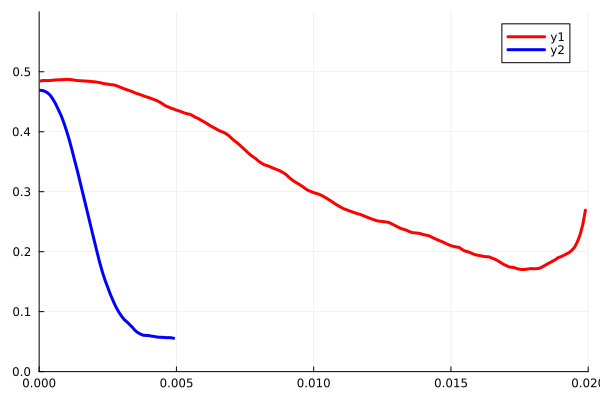

In [318]:
plot(plot_ts, cloud_sizes, linewidth=3, ylim=(0,0.6), xlim=(0,20e-3), color=:red)
plot!(plot_ts_3freq, cloud_sizes_3freq, linewidth=3, color=:blue)

In [311]:
cloud_sizes

200-element Vector{Float64}:
 0.48415430080301236
 0.4851731914645206
 0.48551049665767354
 0.4852629920595002
 0.48551314745215324
 0.4859034569417987
 0.48640862899767456
 0.4866564007573107
 0.4866696278616755
 0.48709678834376485
 0.4874038693543282
 0.4871659680694458
 0.48665485412204795
 ⋮
 0.18648163783311694
 0.18990071680526593
 0.1915406330807314
 0.19364509325686444
 0.1960406174973467
 0.1983340680373815
 0.20217848042343045
 0.20708535499033023
 0.21581246950094907
 0.2274963346287186
 0.24460104148265835
 0.2692384367970871

In [312]:
mean(ensemble_sol[i].prob.p.n_scatters / t_end for i ∈ survived_molecules)

708896.0674157303

In [313]:
function temperature_1D(velocity)
    return m * velocity^2 / kB
end

print("Temperature in μK: ", temperature_1D(sqrt(mean(survived_z_velocities[13][1:floor(Int64,end/2)].^2))) * 1e6)
plot(times[1] .* (1e3/Γ), temperature_1D.(survived_x_velocities[5]) .* 1e6,
    xlabel="Time (ms)",
    ylabel="Temperature along z (μK)"
)

Temperature in μK: 151.7451195353231

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [552]:
goodness(t_end, times, x_trajectories, y_trajectories, z_trajectories, photons_scattered)

LoadError: UndefVarError: `goodness` not defined

In [301]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end) <= 1e-3
            push!(_survived, i)
        end
    end
    return _survived
end

function goodness(t_end, times, x_trajectories, y_trajectories, z_trajectories, photons_scattered)
    
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        # if r > 1.0
        #     n += 0.0
        # elseif r > 0.5
        #     n += 0.1 * exp(-photons_scattered[survived_idx]/14000)
        # elseif r > 0.3
        #     n += (0.6 - r) * exp(-photons_scattered[survived_idx]/14000)
        # elseif r <= 0.3
        #     n += ((0.3 - r) * 3 + 0.3) * exp(-photons_scattered[survived_idx]/14000)
        # end
        if r <= 50e-3
            r = 50e-3
        end
        n += (1/r^3) * exp(-photons_scattered[survived_idx]/14000)
    end
    return n/n_molecules
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end
;

In [554]:
using Serialization, BayesianOptimization, GaussianProcesses

In [555]:
function f(x)
    
    @printf("s1 = %.2f; s2 = %.2f; s3 = %.2f; Δ1 = %.2fΓ; Δ2 = %.2fΓ, Δ3 = %.2fΓ; B_gradient = %.2f; ramp_time = %.2e", x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8] * 1e-3)
    println()
    
    s1 = x[1]
    s2 = x[2]
    s3 = x[3]

    Δ1 = x[4]
    Δ2 = x[5]
    Δ3 = x[6]

    B_gradient = x[7]
    B_ramp_time = x[8] * 1e-3 
    
    prob.p.sim_params.s1 = s1
    prob.p.sim_params.s2 = s2
    prob.p.sim_params.s3 = s3
    prob.p.sim_params.Δ1 = Δ1
    prob.p.sim_params.Δ2 = Δ2
    prob.p.sim_params.Δ3 = Δ3
    prob.p.sim_params.B_gradient = B_gradient
    prob.p.sim_params.B_ramp_time = B_ramp_time
    
    ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)
    
    n_molecules = 20
    @time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleDistributed(); trajectories=n_molecules)
    
    # Analyze all the solutions
    x_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
    y_trajectories = Array{Vector{Float64}}(fill([],n_molecules)) 
    z_trajectories = Array{Vector{Float64}}(fill([],n_molecules))
    x_velocities = Array{Vector{Float64}}(fill([],n_molecules))
    y_velocities = Array{Vector{Float64}}(fill([],n_molecules))
    z_velocities = Array{Vector{Float64}}(fill([],n_molecules))
    photons_scattered = zeros(n_molecules)

    times = Array{Vector{Float64}}(fill([],n_molecules))

    for i ∈ 1:n_molecules
        sol_u = ensemble_sol[i].u
        sol_t = ensemble_sol[i].t

        x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
        y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
        z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]

        x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
        y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
        z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
        
        photons_scattered[i] = ensemble_sol[i].prob.p.n_scatters

        times[i] = sol_t .* (1/Γ)
    end
    
    _goodness = goodness(t_end, times, x_trajectories, y_trajectories, z_trajectories, photons_scattered) * 100

    @printf("goodness = %.3f", _goodness)
    println()
    
    return _goodness
end
;

In [556]:
opt = deserialize("opt_3bluefreq_smallerrange.jl")
;

LoadError: SystemError: opening file "opt_3bluefreq_smallerrange.jl": No such file or directory

In [557]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
plot(moving_average(opt.model.y, 100)) 

LoadError: UndefVarError: `opt` not defined

In [558]:
opt.observed_optimum |> display
opt.observed_optimizer |> display

LoadError: UndefVarError: `opt` not defined

In [559]:
opt.model_optimum |> display
opt.model_optimizer |> display

LoadError: UndefVarError: `opt` not defined

In [90]:
# variables = ["s1", "s2", "s3", "s4", "Δ1=Δ3", "Δ2", "Δ4"]
variables = ["s1", "s2", "s3", "Δ1", "Δ2", "Δ3", "grad", "ramp_time"]

idx1 = 1
idx2 = 4

list1 = opt.lowerbounds[idx1]:0.1:opt.upperbounds[idx1]
list2 = opt.lowerbounds[idx2]:0.1:opt.upperbounds[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(8, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list1, list2, preds_mat')
scatter!(opt.model.x[idx1,:], opt.model.x[idx2,:], legend=nothing, xlabel=variables[idx1], ylabel=variables[idx2])